#Accumulated Local Effects (ALE)  -

for determining the feature effects on a model and how these work on linear and non linear models.

In [ ]:
pip install alibi

     |████████████████████████████████| 225kB 2.8MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 276kB 8.5MB/s 
     |████████████████████████████████| 921kB 8.3MB/s 
     |████████████████████████████████| 204kB 17.4MB/s 
     |████████████████████████████████| 28.0MB 146kB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394112 sha256=122d654e57957b9ce01cf1f52bdfa6dd86a852397cfb48a79506480df581ad44
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052144 sha256=b00b9e694c3b1c17d3931be11aa8a10be3afdc4f2979aeb32f94b3187b83f465
  Stored in directory: /root/.cache/pip/wheels/2a/2b/0a/d6fb6235c56d014d224bca760d15d7cbdd820813085ffcd35d
Successfully built shap spacy-lookups-data
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from alibi.explainers import ALE, plot_ale

The dataset used is Boston Housing Prices(regression).

In [ ]:
data = load_boston()
feature_names = data.feature_names
X = data.data
y = data.target
print(feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

2 separate models, one linear and one non linear, have been applied for analysis -
###1. Linear Regression

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
mean_squared_error(y_test, lr.predict(X_test))

22.098694827098424

###2. Random Forest

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
mean_squared_error(y_test, rf.predict(X_test))

9.91200253543307

Below shown is a scatter plot between the feature 'RM' vs the model predictions.

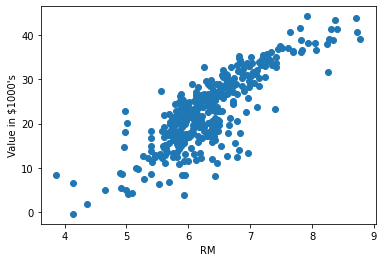

In [ ]:
FEATURE = 'RM'
index = np.where(feature_names==FEATURE)[0][0]

fig, ax = plt.subplots()
ax.scatter(X_train[:, index], lr.predict(X_train));

ax.set_xlabel(FEATURE);
ax.set_ylabel('Value in $1000\'s');

INTERPRETATION -
It is clearly seen that the graph is increasing in nature(positive correlation) i.e. as the value of RM increases, the y axis that shows the price value in 1000's also increases.

To study the influence of all feaatures and not just RM we require ALE to block the effects of other features and discuss the impact of a particular feature.


ALE is a global explanation method that takes in complete data for which the model feature effects are computed.

Applying ALE

In [ ]:
lr_ale = ALE(lr.predict, feature_names=feature_names, target_names=['Value in $1000\'s'])
rf_ale = ALE(rf.predict, feature_names=feature_names, target_names=['Value in $1000\'s'])

In [ ]:
lr_exp = lr_ale.explain(X_train)
rf_exp = rf_ale.explain(X_train)

In [ ]:
lr_exp.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

PLotting ALE first on Linear Regression model(linear) -

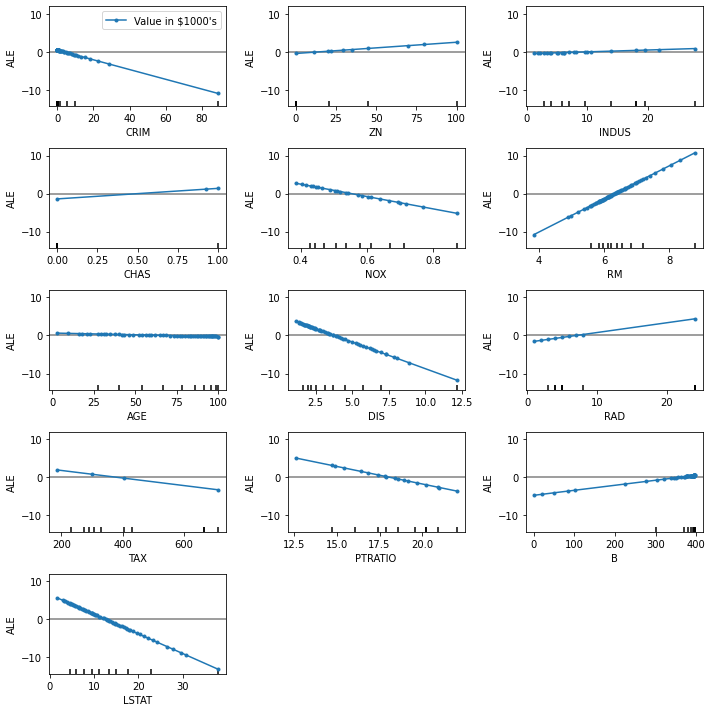

In [ ]:
plot_ale(lr_exp, fig_kw={'figwidth':10, 'figheight': 10});

To study the interpretation, let us consider one feature such as effect of 'RM' and analyse.

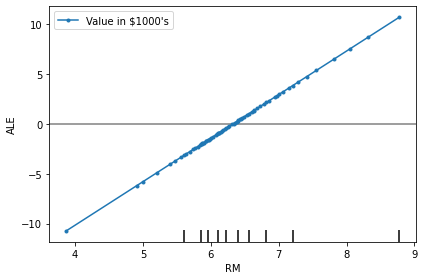

In [ ]:
plot_ale(lr_exp, features=['RM']);

The above plot can be interpreted as follows -
For a particular value of RM on x, the y axis shows how much increase or decrease(positive-increase, negative-decrease) is done on the price. 
The ALE on the y-axis of the plot above is in the units of the prediction variable which, in this case, is the value of the house in $1000's. 

For example, the ALE value for the point RM=8 is ~7.5. this means that the for neighbourhoods for which the average number of rooms is ~8 the model predicts an increase of ~$7500 due to feature RM. On the other hand, for neighbourhoods with an average number of rooms lower than ~6.25, the impact on the prediction becomes negative, i.e. a smaller number of rooms lowers the predicted value.

All ALE values are relative to the average prediction which is discussed in detail below-

The neighbourhoods for which the average number of rooms are close to 8 -

In [ ]:
lower_index = np.where(lr_exp.feature_values[5] < 8)[0][-1]
upper_index = np.where(lr_exp.feature_values[5] > 8)[0][0]
subset = X_train[(X_train[:, 5] > lr_exp.feature_values[5][lower_index])
                 & (X_train[:, 5] < lr_exp.feature_values[5][upper_index])]
print(subset.shape)

(6, 13)


The mean prediction on this subset is -

In [ ]:
subset_pred = lr.predict(subset).mean()
subset_pred

38.71963302852489

The mean prediction averaged across the whole dataset is-

In [ ]:
mean_pred = lr.predict(X_train).mean()
mean_pred

22.907915567282302

In [ ]:
subset_pred - mean_pred

15.811717461242587

This difference is the total increase in prive in 1000's for neigbourhoods with the average room number close to 8. We have subtracted the mean averaged over entire dataset from prediction on subset(RM~8) since the ALE is always relative to the average prediction.

Let us take another example to analyse the advantage and need of using ALE over other methods-

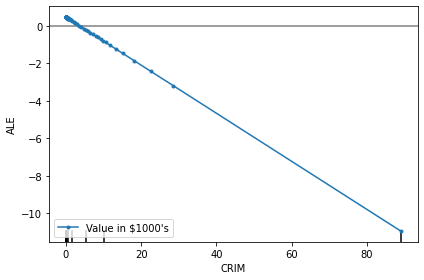

In [ ]:
#Crime level
plot_ale(lr_exp, features=['CRIM']);

ALE plot though being a global interpretation method and thus taking the whole dataset in consideration, gives feature effects for all values separately, unlike PDP and other feature importance plots. For example, in the above plot, the dots show the value of ALE on y axis for every value of the feature CRIM. The individual dots in the plot shows individual values instead of calculating the importance in general. For eg, at CRIM ~ 30, the ALE value is -3 showing that the model predicts a decrease of $3000 in price(higher the crime level, the lower is the price).

From interval 30 to 85, due to lack of or no data, it has simply interpolated the line.

Thus, these can help assess in which areas of the feature space, the estimated results of feature importance are more reliable.

Similarly , now ALE is applied on Random Forest model (non-linear) -

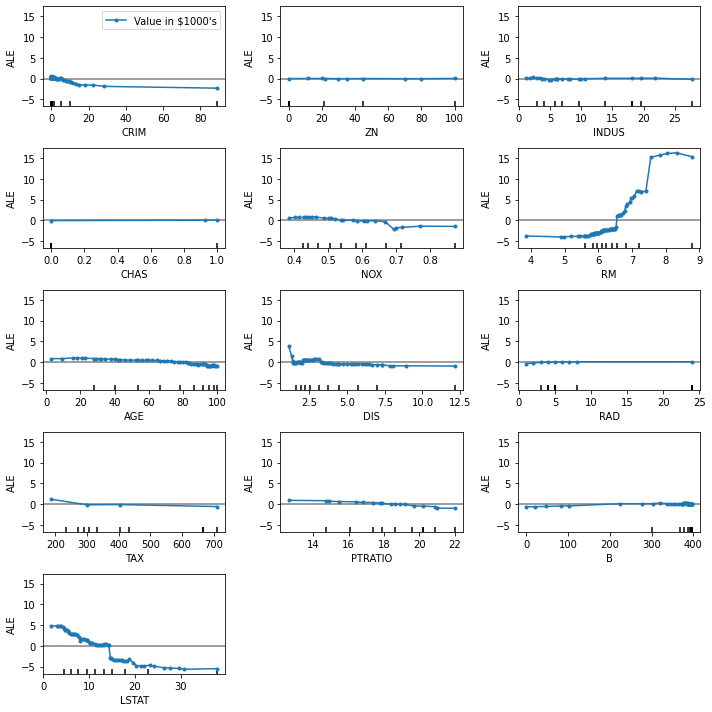

In [ ]:
axes = plot_ale(rf_exp, fig_kw={'figwidth':10, 'figheight': 10});

Because the model is non-linear, the ALE plots are non-linear and non-monotonic in some cases. Similar to the previous examples,the ALE value at a point is the relative feature effect with respect to the mean feature effect. 

From these plots, it is seen that that the feature RM has the largest impact on the prediction. 

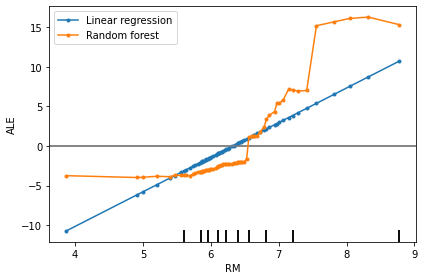

In [ ]:
fig, ax = plt.subplots()
plot_ale(lr_exp, features=['RM'], ax=ax, line_kw={'label': 'Linear regression'});
plot_ale(rf_exp, features=['RM'], ax=ax, line_kw={'label': 'Random forest'});

INTERPRETATION-

While the linear regression feature effects of RM are positively correlated (the higher the no. of rooms, the higher the price), the random forest feature effects are increasing in a non linear fashion.


###Comparing ALE for Linear Regression and Random Forest for all the features

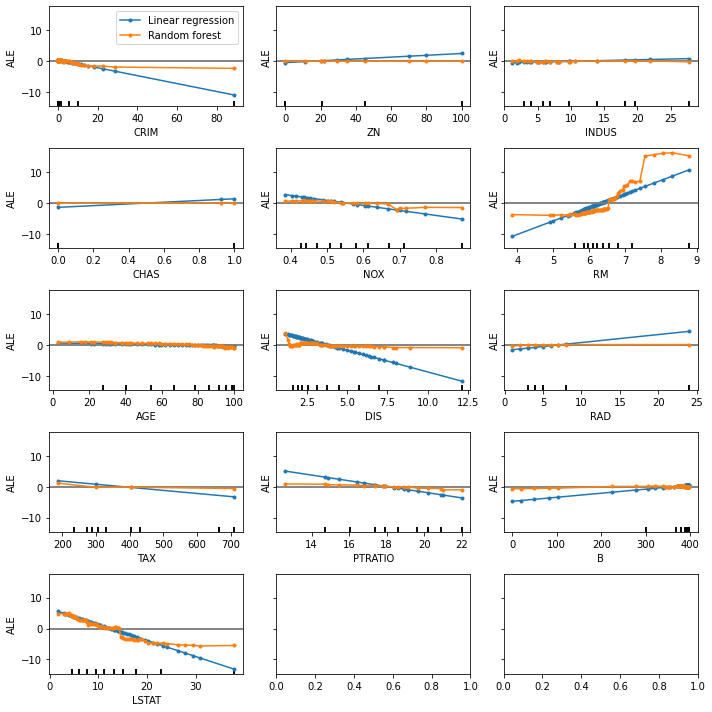

In [ ]:
fig, ax = plt.subplots(5, 3, sharey='all');

plot_ale(lr_exp, ax=ax, fig_kw={'figwidth':10, 'figheight': 10},
         line_kw={'label': 'Linear regression'});
plot_ale(rf_exp, ax=ax, line_kw={'label': 'Random forest'});